# **Import Libraries**

In [1]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

In [2]:
# libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
# preprocessing, modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

In [4]:
print(tf.__version__)

2.19.0


In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
from google.colab import files
files.upload()  # Upload file kaggle.json kamu

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list | head

Saving kaggle.json to kaggle.json
ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           6806        269  1.0              
jaderz/hospital-beds-management                               Hospital Beds Management                                47583  2025-10-03 09:21:58.590000           5557        154  1.0              
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000          11798        254 

# **Data Loading**

In [18]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:25<00:00, 83.0MB/s]
100% 2.29G/2.29G [00:25<00:00, 94.8MB/s]


In [19]:
!ls /content

 chest-xray-pneumonia.zip  'kaggle (2) (2).json'   sample_data
 drive			   'kaggle (2).json'
'kaggle (2) (1).json'	    kaggle.json


In [20]:
import zipfile

with zipfile.ZipFile("/content/chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/chest_xray")

!ls /content/chest_xray

chest_xray


In [21]:
extract_dir = '/content/chest_xray/chest_xray'

In [23]:
train_dir = os.path.join(extract_dir, 'train')
val_dir = os.path.join(extract_dir, 'val')
test_dir = os.path.join(extract_dir, 'test')

In [24]:
def count_file(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'jumlah {label} : {num_data}')

labels= ['PNEUMONIA','NORMAL']
print('Train Set: \n' + '='*50)
count_file(train_dir,labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir,labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir,labels)

Train Set: 
jumlah PNEUMONIA : 3875
jumlah NORMAL : 1341

Validation Set: 
jumlah PNEUMONIA : 8
jumlah NORMAL : 8

Test Set: 
jumlah PNEUMONIA : 390
jumlah NORMAL : 234


In [25]:
def get_file_sizes(directory):
    file_sizes = []
    #menjelajahi struktur direktori
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

In [26]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/chest_xray/chest_xray/train/PNEUMONIA/person1121_virus_1846.jpeg',
  'size_kb': 77.69},
 {'file': '/content/chest_xray/chest_xray/train/PNEUMONIA/person669_bacteria_2561.jpeg',
  'size_kb': 38.313},
 {'file': '/content/chest_xray/chest_xray/train/PNEUMONIA/person492_virus_998.jpeg',
  'size_kb': 115.031},
 {'file': '/content/chest_xray/chest_xray/train/PNEUMONIA/person257_bacteria_1199.jpeg',
  'size_kb': 88.214},
 {'file': '/content/chest_xray/chest_xray/train/PNEUMONIA/person24_bacteria_110.jpeg',
  'size_kb': 77.488}]

In [27]:
def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)

    df = pd.DataFrame(data)
    return df

In [28]:
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)

print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [29]:
train_df.head(3)

,file,size_kb
0,/content/chest_xray/chest_xray/train/PNEUMONIA...,77.690
1,/content/chest_xray/chest_xray/train/PNEUMONIA...,38.313
2,/content/chest_xray/chest_xray/train/PNEUMONIA...,115.031


In [30]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'

dict_dir_df = {'train': train_df,
               'val': val_df,
               'test': test_df}

In [31]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [32]:
train_df.sample(3)

,file,size_kb,label
1897,/content/chest_xray/chest_xray/train/PNEUMONIA...,49.935,pneumonia
877,/content/chest_xray/chest_xray/train/PNEUMONIA...,79.536,pneumonia
4503,/content/chest_xray/chest_xray/train/NORMAL/IM...,744.807,normal


In [33]:
def get_image_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)  # Default value jika image tidak bisa di read

In [34]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)

In [35]:
# Filter hanya baris dengan 'dimensi' lebih besar dari sama dengan 3
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
val: 0
test: 0


In [36]:
train_df.sample(3)

,file,size_kb,label,dimensions
318,/content/chest_xray/chest_xray/train/PNEUMONIA...,57.961,pneumonia,"(1120, 592)"
4221,/content/chest_xray/chest_xray/train/NORMAL/NO...,431.897,normal,"(1442, 1229)"
5028,/content/chest_xray/chest_xray/train/NORMAL/NO...,611.279,normal,"(1720, 1380)"


In [37]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


In [38]:
merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [39]:
train_df, test_df_full = train_test_split(merged_df, test_size=0.3,
                                    stratify = merged_df['label'], random_state=42)

test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                                    stratify = test_df_full['label'], random_state=42)

In [40]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


# **EXPLORATORY DATA ANALYSIS (EDA)**

In [41]:
# create a subplot
fig = make_subplots(rows=1, cols=2,
                    #subplot_titles=['Bar Chart', 'Pie Chart'],
                    specs=[[{'type': 'xy'}, {'type': 'domain'}]])

# Bar Chart
bar_chart = go.Figure(go.Bar(x=train_df['label'].value_counts().index,
                             y=train_df['label'].value_counts().values,
                             marker_color=['#fe346e', '#2c003e']))
fig.add_trace(bar_chart['data'][0], row=1, col=1)

# Pie Chart
pie_chart = go.Figure(go.Pie(labels=train_df['label'].value_counts().index,
                             values=train_df['label'].value_counts().values,
                             #marker_colors=['#fe346e', '#2c003e'],
                             marker=dict(
                                 colors=['#fe346e', '#2c003e'],
                                 line=dict(color='gray', width=3)),
                             pull=[0.05, 0]) # Efek exploded
                     )
fig.add_trace(pie_chart['data'][0], row=1, col=2)

# Update layout
fig.update_layout(showlegend=False, # Optional: to hide legends
                 title='Distribution of Diagnosis on Training Set',
                 title_x=0.5,#title position (center)
                 shapes=[dict(type='line', x0=0.5, y0=0, x1=0.5, y1=1,
                              line=dict(color='#000000', width=2))]
                )

fig.show()

In [42]:
# Hitung rata-rata height dan width
height_mean = train_df['dimensions'].apply(lambda x: x[0]).mean()
width_mean = train_df['dimensions'].apply(lambda x: x[1]).mean()

print(f"The average height of the images is {height_mean:.2f} pixels")
print(f"The average width of the images is {width_mean:.2f} pixels")

The average height of the images is 1322.58 pixels
The average width of the images is 967.02 pixels


In [43]:
dict_dir_df = {'train': train_df,
               'val': val_df,
               'test': test_df}

for name, df in dict_dir_df.items():
    print(f"minimum file sizes in {name}: {df['size_kb'].min()}")

minimum file sizes in train: 5.313
minimum file sizes in val: 6.352
minimum file sizes in test: 8.753


In [44]:
for name, df in dict_dir_df.items():
    print(f"minimum file sizes in {name}: {df['size_kb'].max()}")

minimum file sizes in train: 2357.756
minimum file sizes in val: 2074.266
minimum file sizes in test: 1804.62


In [45]:
# Ekstrak tinggi (height) dan lebar (width) dari kolom "dimensions"
heights, widths = zip(*train_df['dimensions'])

#boxplot
fig = px.box(x=['Height']*len(heights) + ['Width']*len(widths),
             y=list(heights) + list(widths),
             labels={'x': 'Dimension Type', 'y': 'Pixels'},
             points='outliers',
             title="Boxplot of Image Dimensions (Height and Width)",
            )

fig.update_traces(marker_color='#fe346e', marker_line_color='#fe346e',
                  marker_line_width=1, opacity=1)

fig.show()

In [128]:
def plot_images(image_path, label, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
    num_images= min(nrows*ncols, len(image_path)) # Plot only available images
    for i in range(num_images):
        img = Image.open(image_path[i])
        row_idx, col_idx = divmod(i, ncols)
        axes[row_idx, col_idx].imshow(img,cmap='gray')
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_title(f'{label}\nShape: {img.size}')

    # Hide any unused subplots
    for i in range(num_images, nrows * ncols):
        row_idx, col_idx = divmod(i, ncols)
        axes[row_idx, col_idx].axis('off')

    plt.show()

pneumonia_path = train_df.query("label=='pneumonia'")['file'].values
normal_path = train_df.query("label=='normal'")['file'].values

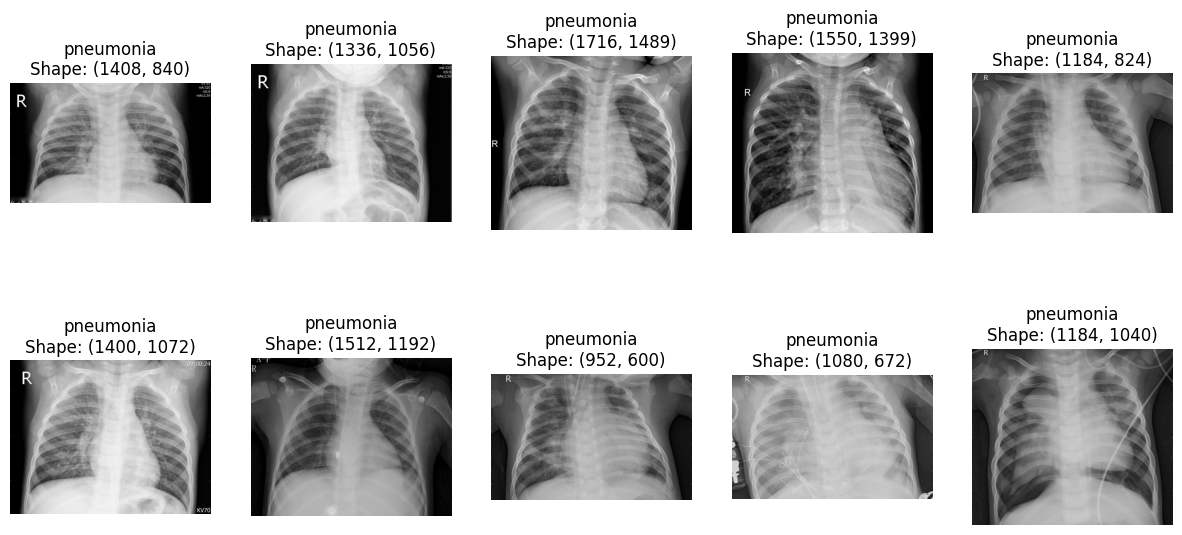

In [47]:
plot_images(pneumonia_path, 'pneumonia')

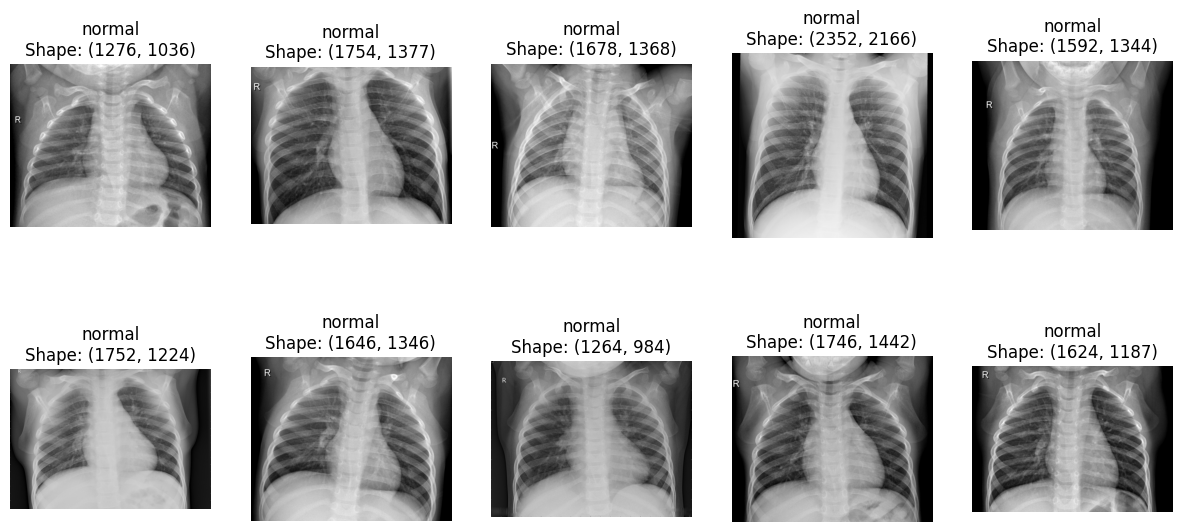

In [48]:
plot_images(normal_path, 'normal')

In [49]:
# Filter data train berdasarkan sizes-nya di bawah 10 kb
filtered_pneumonia_path = train_df.query("label=='pneumonia' and size_kb < 10")['file'].values
filtered_normal_path = train_df.query("label=='normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_path))
print(len(filtered_normal_path))

37
0


In [50]:
# Filter data test berdasarkan sizes-nya di bawah 10 kb
filtered_pneumonia_test = test_df.query("label=='pneumonia' and size_kb < 10")['file'].values
filtered_normal_test = test_df.query("label=='normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_test))
print(len(filtered_normal_test))

2
0


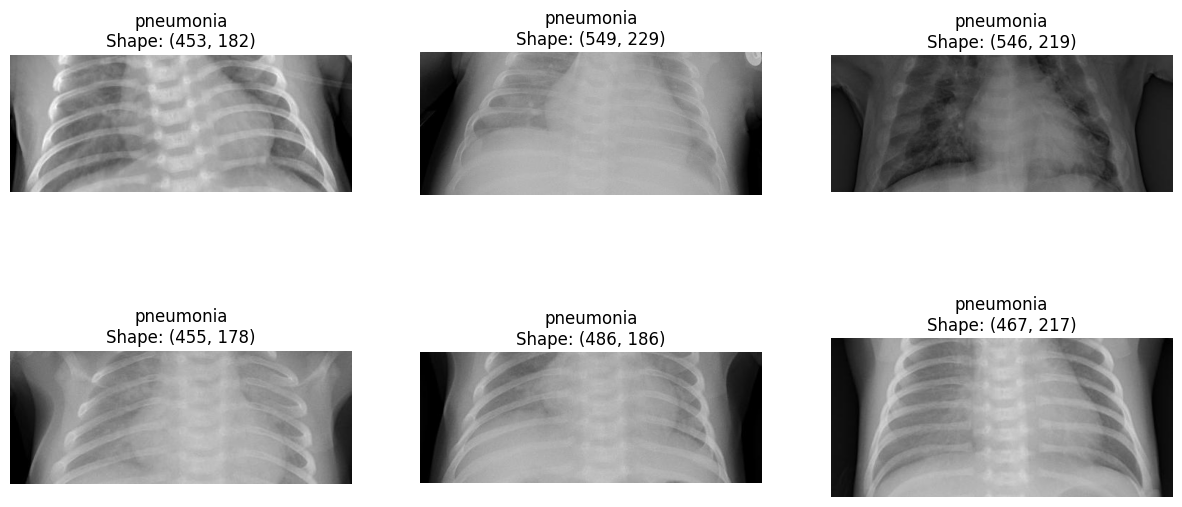

In [51]:
plot_images(filtered_pneumonia_path, 'pneumonia', nrows=2, ncols=3)

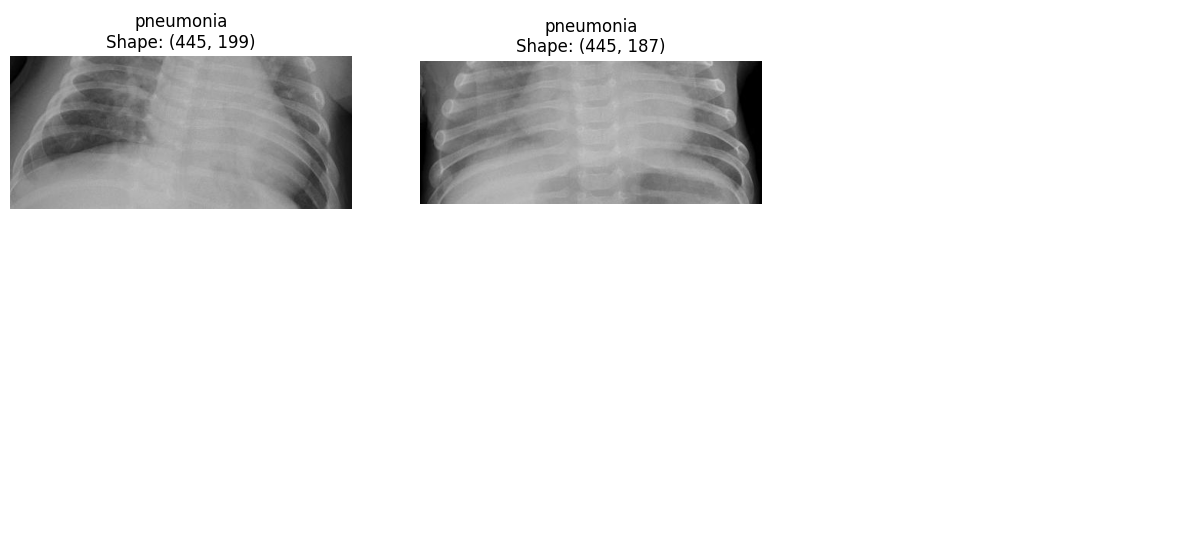

In [129]:
plot_images(filtered_pneumonia_test, 'pneumonia', nrows=2, ncols=3)

In [130]:
pneumonia_path

array(['/content/chest_xray/chest_xray/test/PNEUMONIA/person1678_virus_2895.jpeg',
       '/content/chest_xray/chest_xray/train/PNEUMONIA/person1534_virus_2670.jpeg',
       '/content/chest_xray/chest_xray/train/PNEUMONIA/person1481_virus_2567.jpeg',
       ...,
       '/content/chest_xray/chest_xray/train/PNEUMONIA/person1402_virus_2405.jpeg',
       '/content/chest_xray/chest_xray/train/PNEUMONIA/person481_bacteria_2041.jpeg',
       '/content/chest_xray/chest_xray/train/PNEUMONIA/person963_virus_1636.jpeg'],
      dtype=object)

In [131]:
tf.strings.split('/content/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg', os.path.sep)

<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'', b'content', b'chest_xray', b'chest_xray', b'train',
       b'PNEUMONIA', b'person1180_virus_2010.jpeg'], dtype=object)>

# **DATA PREPROCESSING**

In [184]:
def preprocess_image(file_path, label, channels=3):
    # Membaca file gambar
    img = tf.io.read_file(file_path)

    # Mendekode gambar ke dalam tensor
    img = tf.image.decode_jpeg(img, channels=channels)

    # Mengubah ukuran gambar sesuai dengan kebutuhan model Anda
    img = tf.image.resize(img, [32, 32])

    # Normalisasi nilai piksel menjadi rentang [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Konversi label menjadi numerik (0 untuk normal, 1 untuk pneumonia)
    # label = tf.cond(tf.math.equal(label, tf.constant('normal')), lambda: 0, lambda: 1)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)


    return img, label

In [185]:
def color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image

In [186]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

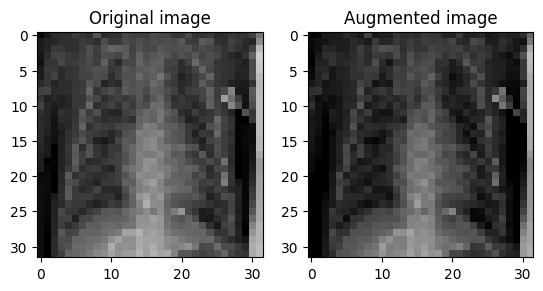

In [187]:
import os
import tensorflow as tf
from PIL import Image

# Path baru, sesuai dataset hasil ekstraksi dari Kaggle
image_path = '/content/chest_xray/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'

# Panggil fungsi preprocessing dan augmentasi
img, label = preprocess_image(image_path, 'pneumonia', channels=3)
color_jiter_test = color_jitter(img, seed=3)

# Visualisasi hasil sebelum dan sesudah augmentasi
visualize(img, color_jiter_test)

In [188]:
img.shape

TensorShape([32, 32, 3])

In [189]:
number = train_df.shape[0]
factors = []

# Loop untuk mencari faktor-faktor pembagi
for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)

# Cetak faktor-faktor pembagi
print("Faktor-faktor pembagi dari", number, "adalah:", factors)

Faktor-faktor pembagi dari 4099 adalah: [1, 4099]


In [190]:
# Konstanta untuk peningkatan otomatis kinerja dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Ukuran batch untuk pelatihan model
batch_size = 32

In [191]:
# Fungsi augmentasi untuk data train
def augment_train_image(img, label):
    # Tambahkan augmentasi sesuai kebutuhan Anda
    #img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_flip_up_down(img)
    img= color_jitter(img, seed=3)
    return img, label

# Fungsi augmentasi untuk data val
def augment_val_image(img, label):
    # Tambahkan augmentasi sesuai kebutuhan
    return img, label

layers_augmentation = tf.keras.Sequential([
            #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In [192]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):
    # Map preprocess_image function ke dataset
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)


    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds

In [193]:
# Buat dataset train menggunakan tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
# train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.batch(batch_size)
# train_ds = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)

# Buat dataset val
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset,batch_size, shuffle=False)

# Buat dataset test
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [194]:
# Contoh iterasi melalui dataset troain
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 32, 32, 3)
Batch Size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


In [195]:
# Contoh iterasi melalui dataset train
for images, labels in val_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 32, 32, 3)
Batch Size: 32
Labels: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0]


In [196]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.02502534 0.02502534 0.12311244 ... 0.02502534 0.0674147  0.03685492]
 [0.02502534 0.02502534 0.09994611 ... 0.02502534 0.5285226  1.0219154 ]
 [0.02502534 0.02502534 0.08787006 ... 0.02502534 0.02502534 1.0150149 ]
 ...
 [0.02502534 0.02502534 0.08392689 ... 0.02502534 0.02502534 0.02502534]
 [0.06371796 0.07899785 0.19778678 ... 0.02502534 0.02502534 0.02502534]
 [0.20123705 0.16328377 0.3478748  ... 0.02502534 0.02502534 0.02502534]], shape=(32, 32), dtype=float32)


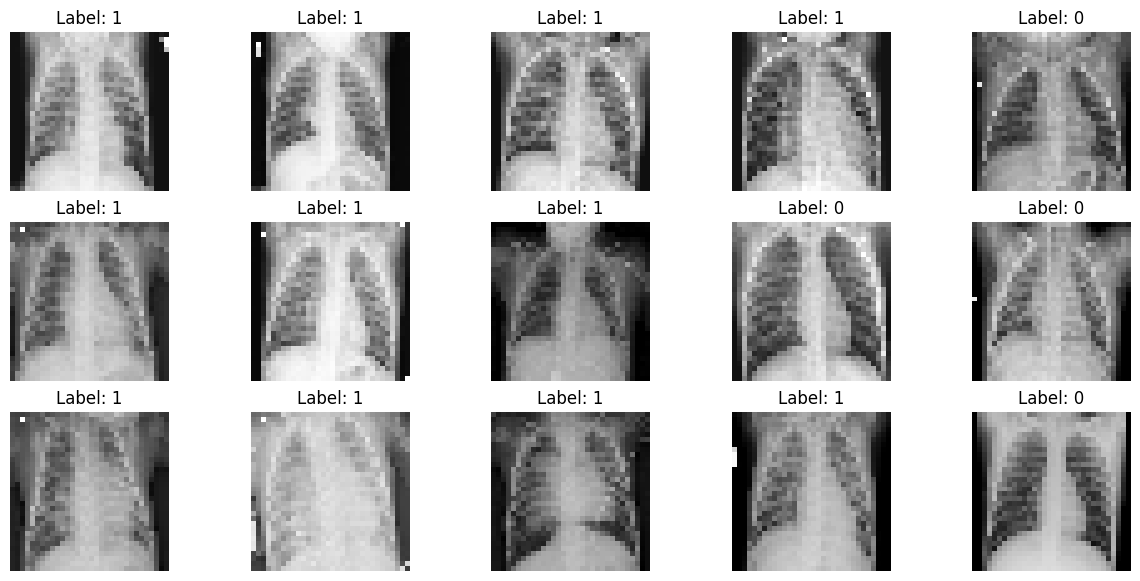

In [197]:
# Ambil satu batch dari dataset
for images, labels in train_ds.take(1):
    # Visualisasi beberapa gambar dari batch pertama
    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)  # Ubah parameter subplot menjadi 3 baris dan 5 kolom
        #plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

# **MODEL DEVELOPMENT**

### **Transfer Learning (LeNet-5)**

In [198]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

Catatan:
Global Average Pooling adalah teknik yang digunakan untuk mereduksi dimensi spasial dari data. Pada kasus ini, untuk setiap "channel" (saluran) dari data, kita hanya memiliki satu nilai rata-rata. Hal ini membantu mengurangi jumlah parameter dalam model dan mencegah overfitting, sambil tetap mempertahankan informasi yang relevan.

In [199]:
input_shape = (32, 32, 3)
num_classes = 1

# Membangun arsitektur LeNet-5 yang dimodifikasi
model_2 = Sequential()

# Convolutional Layer 1
model_2.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))
model_2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional Layer 2
model_2.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model_2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten the output from convolutional layers
model_2.add(Flatten())

# Dense Layer 1
model_2.add(Dense(400, activation='relu'))

# Dense Layer 2
model_2.add(Dense(84, activation='relu'))

# Output Layer
model_2.add(Dense(num_classes, activation='softmax'))

In [200]:
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        33,684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,041 (769.69 KB)

 Trainable params: 197,041 (769.69 KB)

 Non-trainable params: 0 (0.00 B)

Pada model di atas kita menggunakan flatten(), karena setelah di uji coba walaupun mengsilkan overfit, score pada test lebih bagus ketika menggunakan flatten() dibandingkan dengan GlobalAveragePooling2D().

In [201]:
from keras.metrics import AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

# Mengatur learning rate
learning_rate = 0.01  # default 0.001
optimizer = Adam(learning_rate=learning_rate)

# Mengompilasi model dengan optimizer
model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[AUC(name='auc')])

Pada model transfer learning kita akan mencoba mengatur learning rate yang lebih tinggi atau lebih cepat dibandingkan dengan model-model sebelumnya.

In [202]:
checkpoint_filepath2 = '/tmp/checkpoint2.weights.h5'
checkpoint_dir2 = os.path.dirname(checkpoint_filepath2)

callbacks_2 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath2, monitor='val_loss', mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [203]:
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks_2,
    verbose=1
)

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - auc: 0.5000 - loss: 0.6149 - val_auc: 0.5000 - val_loss: 0.5492 - learning_rate: 0.0100
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5000 - loss: 0.5189 - val_auc: 0.5000 - val_loss: 0.3273 - learning_rate: 0.0100
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5000 - loss: 0.2303 - val_auc: 0.5000 - val_loss: 0.2431 - learning_rate: 0.0100
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5000 - loss: 0.1976 - val_auc: 0.5000 - val_loss: 0.2920 - learning_rate: 0.0100
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5000 - loss: 0.2476 - val_auc: 0.5000 - val_loss: 0.3431 - learning_rate: 0.0100


In [204]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_auc = history_name.history['auc']
    val_auc = history_name.history['val_auc']
    return train_loss, val_loss, train_auc, val_auc

In [205]:
def plot_training_history(history_name=None,start_epoch=1):
    # Pastikan history_name tidak None
    if history_name is None:
        raise ValueError("Parameter 'history_name' harus diisi dengan objek riwayat (history).")

    # Ambil data pelatihan dari objek history
    train_loss, val_loss, train_auc, val_auc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    # learning_rate = history_name.history['lr']


    # Buat plot untuk loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    # plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Buat plot untuk accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_auc, label='Training AUC',marker='o',color='red')
    plt.plot(range_epoch, val_auc, label='Validation AUC',marker='x',color='blue')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

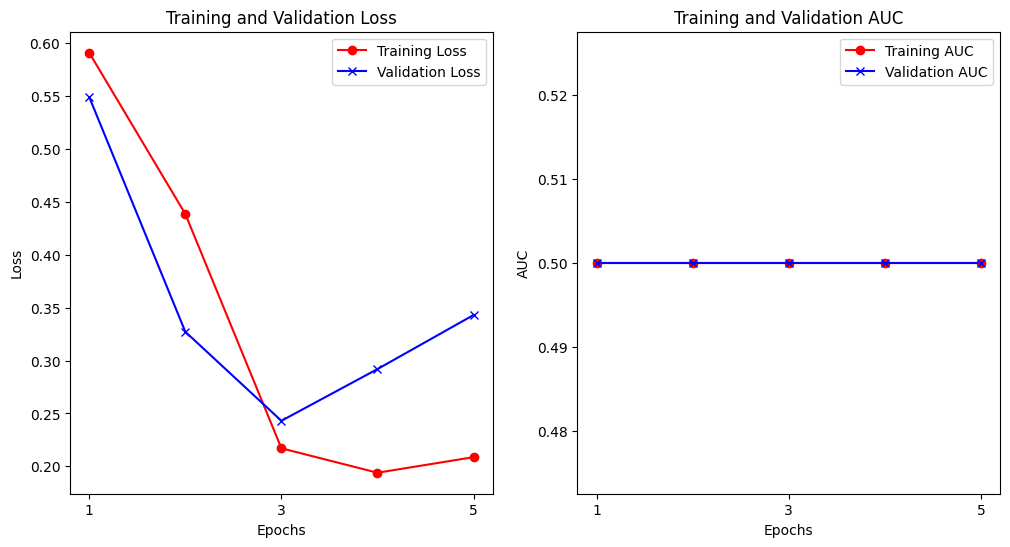

In [206]:
plot_training_history(history_name=history_2)

In [207]:
model_2.load_weights(checkpoint_filepath2)

In [208]:
def evaluate(data=None, model=None):
    loss, auc = model.evaluate(data, verbose=2)
    print("Restored model, auc: {:5.2f}%".format(100 * auc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [209]:
evaluate(val_ds,model_2)

28/28 - 0s - 3ms/step - auc: 0.5000 - loss: 0.2431
Restored model, auc: 50.00%
Restored model, loss: 24.31%


In [210]:
evaluate(train_ds,model_2)

129/129 - 1s - 8ms/step - auc: 0.5000 - loss: 0.2085
Restored model, auc: 50.00%
Restored model, loss: 20.85%


In [211]:
evaluate(test_ds,model_2)

28/28 - 6s - 229ms/step - auc: 0.5000 - loss: 0.2163
Restored model, auc: 50.00%
Restored model, loss: 21.63%


In [212]:
model_2.save('model_2.keras')

In [213]:
tf.keras.backend.clear_session()

In [214]:
# Mendefinisikan fungsi untuk membuat prediksi
def predict_and_evaluate(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghasilkan classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [215]:
# Memuat model
model_path= 'model_2.keras'
loaded_model_2 = tf.keras.models.load_model('model_2.keras')

# Membuat classification report
classification_report_result = predict_and_evaluate(loaded_model_2, test_ds)

# Menampilkan classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       237
   pneumonia       0.73      1.00      0.84       641

    accuracy                           0.73       878
   macro avg       0.37      0.50      0.42       878
weighted avg       0.53      0.73      0.62       878



In [216]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghitung confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Ekstraksi TP, FP, TN, FN
    #gunakan ravel() atau flatten() untuk mendapatkan array satu dimensi
    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

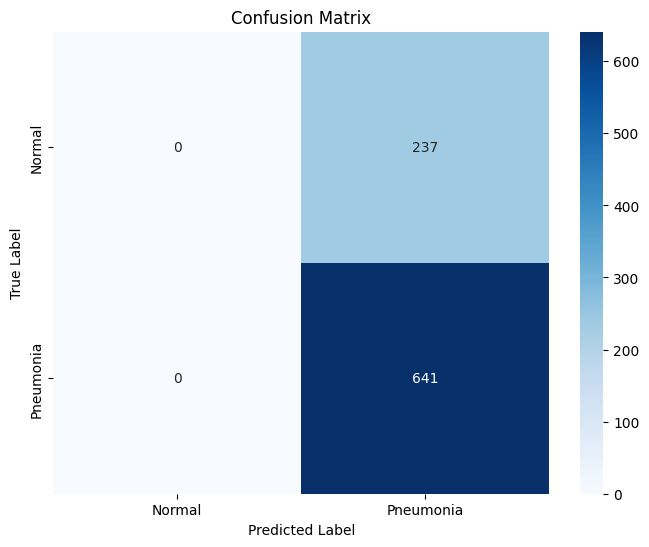

True Positive (TP): 641
False Positive (FP): 237
True Negative (TN): 0
False Negative (FN): 0


In [217]:
# Menghitung confusion matrix dari model terload dan dataset test
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_2, test_ds)

# Menampilkan hasil
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

In [218]:
def calculate_specificity(tn, fp):
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

specificity_model2 = calculate_specificity(tn, fp)
print("Specificity (True Negative Rate):", specificity_model2.round(2))

Specificity (True Negative Rate): 0.0


In [219]:
def calculate_sensitivity(tp, fn):
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    return sensitivity

sensitivity_model2 = calculate_sensitivity(tp, fn)
print("Sensitivity (True Positive Rate):", sensitivity_model2.round(2))

Sensitivity (True Positive Rate): 1.0


Hasil dari training dengan LeNet-5 menghasilkan score auc yang lebih kecil dibandingkan model sebelumnya. Sama sekali tidak ada memprediksi nilai TN dan FN.